# Film recommendation engine based on my history list from Trakt.tv

> This notebook aims at building a recommendation engine from the content of my history list that contains around 1000 movies.

Recommendation engines are of three kinds :
* **popularity-based** : the most simple be also the most impersonal
* **content-based** : the recommendations are based on the description of the products
* **collaborative filtering** : records from various users provide recommendations based on user similarities

Now, I only will focus on the content and popularity of the films, thus collaborative filtering is excluded.

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

from wordcloud import WordCloud

import pandas as pd
import numpy as np

from collections import Counter
import requests
import json
import time

from backports import configparser

config = configparser.ConfigParser()
config.read('config.ini')

CLIENT_ID = config.get('TRAKT','CLIENT_ID')
CLIENT_SECRET = config.get('TRAKT','CLIENT_SECRET')
OAUTH_TOKEN = config.get('TRAKT','OAUTH_TOKEN')

headers = {
  'Content-Type': 'application/json',
  'trakt-api-version': '2',
  'trakt-api-key': CLIENT_ID
}

## Get Data

In [194]:
# user slug
user_id = 'synyss' 

# Get extended info
history = 'https://api.trakt.tv/users/{}/history/movies?limit=1000&extended=full'.format(user_id)
resp = requests.get(history, headers=headers)

response_body = resp.json()
len(response_body)
# print(response_body)
# for pretty json print, uncomment :
print(json.dumps(response_body[0], indent=2))

{
  "id": 5746549317,
  "watched_at": "2020-03-10T19:09:00.000Z",
  "action": "watch",
  "type": "movie",
  "movie": {
    "title": "Lost in Translation",
    "year": 2003,
    "ids": {
      "trakt": 118,
      "slug": "lost-in-translation-2003",
      "imdb": "tt0335266",
      "tmdb": 153
    },
    "tagline": "Everyone wants to be found.",
    "overview": "Two lost souls visiting Tokyo -- the young, neglected wife of a photographer and a washed-up movie star shooting a TV commercial -- find an odd solace and pensive freedom to be real in each other's company, away from their lives in America.",
    "released": "2003-09-18",
    "runtime": 102,
    "country": "us",
    "trailer": "http://youtube.com/watch?v=1s4YQqnbnM8",
    "homepage": null,
    "status": "released",
    "rating": 7.68724,
    "votes": 7194,
    "comment_count": 30,
    "updated_at": "2020-03-02T08:20:46.000Z",
    "language": "en",
    "available_translations": [
      "bg",
      "cs",
      "da",
      "de",
   

In [4]:
df = pd.DataFrame()

for data in response_body:
    df = df.append({
            'title' : data['movie']['title'],
            'year' : data['movie']['year'],
            'watched_at' : data['watched_at'],
            'ids' : data['movie']['ids'],
            'tagline' : data['movie']['tagline'],
            'overview' : data['movie']['overview'],
            'released' : data['movie']['released'],
            'duration' : data['movie']['runtime'],
            'country' : data['movie']['country'],
            'rating' : data['movie']['rating'],
            'votes' : data['movie']['votes'],
            'language' : data['movie']['language'],
            'genres' : data['movie']['genres'],
            'certification' : data['movie']['certification']
        }, ignore_index=True)
    
df.to_csv('data/movies_history.csv', index=False)

In [2]:
df = pd.read_csv('data/movies_history.csv')

In [3]:
df = df.drop_duplicates(subset='ids')

In [4]:
df.head()

,certification,country,duration,genres,ids,language,overview,rating,released,tagline,title,votes,watched_at,year
0,R,us,102.0,"['drama', 'romance', 'comedy']","{'trakt': 118, 'slug': 'lost-in-translation-20...",en,"Two lost souls visiting Tokyo -- the young, ne...",7.68716,2003-09-18,Everyone wants to be found.,Lost in Translation,7189.0,2020-03-10T19:09:00.000Z,2003.0
1,R,us,137.0,"['action', 'science-fiction', 'drama', 'superh...","{'trakt': 161972, 'slug': 'logan-2017', 'imdb'...",en,"In the near future, a weary Logan cares for an...",7.98986,2017-03-03,His time has come,Logan,54447.0,2020-03-09T20:25:00.000Z,2017.0
2,PG-13,us,106.0,"['action', 'adventure', 'comedy']","{'trakt': 4757, 'slug': 'charlie-s-angels-full...",en,The Angels are charged with finding a pair of ...,5.80007,2003-06-27,This summer the Angels are back.,Charlie's Angels: Full Throttle,2811.0,2020-03-08T20:08:21.000Z,2003.0
3,PG-13,us,98.0,"['action', 'adventure', 'comedy', 'crime', 'th...","{'trakt': 2541, 'slug': 'charlie-s-angels-2000...",en,"Three women, detectives with a mysterious boss...",6.12826,2000-11-02,Get Some Action,Charlie's Angels,4288.0,2020-03-08T20:08:12.000Z,2000.0
4,NaN,us,108.0,"['drama', 'romance']","{'trakt': 221327, 'slug': 'all-the-bright-plac...",en,Two teens facing personal struggles form a pow...,7.04950,2020-02-28,Live life at full brightness,All the Bright Places,404.0,2020-03-08T19:59:00.000Z,2020.0


In [5]:
import ast # because of string representation of list

def listToString(s):
    '''for convenient print of genre'''
    str1 = "|"
    return (str1.join(s))

df['genres'] =  df['genres'].apply(lambda x : listToString(ast.literal_eval(x)))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906 entries, 0 to 918
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   certification  809 non-null    object 
 1   country        896 non-null    object 
 2   duration       905 non-null    float64
 3   genres         906 non-null    object 
 4   ids            906 non-null    object 
 5   language       905 non-null    object 
 6   overview       906 non-null    object 
 7   rating         906 non-null    float64
 8   released       904 non-null    object 
 9   tagline        791 non-null    object 
 10  title          906 non-null    object 
 11  votes          906 non-null    float64
 12  watched_at     906 non-null    object 
 13  year           904 non-null    float64
dtypes: float64(4), object(10)
memory usage: 106.2+ KB


In [7]:
df[df['year'].isnull()]

,certification,country,duration,genres,ids,language,overview,rating,released,tagline,title,votes,watched_at,year
378,NaN,us,46.0,documentary,"{'trakt': 394186, 'slug': 'inside-medical-mari...",en,"In Northern California's Emerald Triangle, mor...",9.00000,NaN,NaN,Inside: Medical Marijuana,1.0,2019-08-27T18:36:11.000Z,NaN
666,NaN,NaN,0.0,,"{'trakt': 228037, 'slug': 'dragon-ball-super',...",ja,"With Majin Boo defeated, peace returns to Eart...",8.08871,NaN,Doragon Bōru Sūpā,Dragon Ball Super,124.0,2018-11-12T19:55:32.000Z,NaN


In [8]:
# drop dragon-ball-super and 2011 for inside-medical-marijuana

df.drop([666], inplace=True)

df.at[378, 'year'] = 2011

In [9]:
df = df.astype({'year': int})

In [10]:
df.describe()

,duration,rating,votes,year
count,904.000000,905.000000,905.000000,905.000000
mean,110.085177,7.034109,10175.738122,2008.075138
std,25.157894,0.836851,10982.853958,8.847459
min,0.000000,3.116580,1.000000,1968.000000
25%,96.000000,6.538570,2213.000000,2004.000000
50%,109.000000,7.083860,6526.000000,2010.000000
75%,124.000000,7.625780,14467.000000,2015.000000
max,201.000000,9.500000,84750.000000,2020.000000


## Exploration

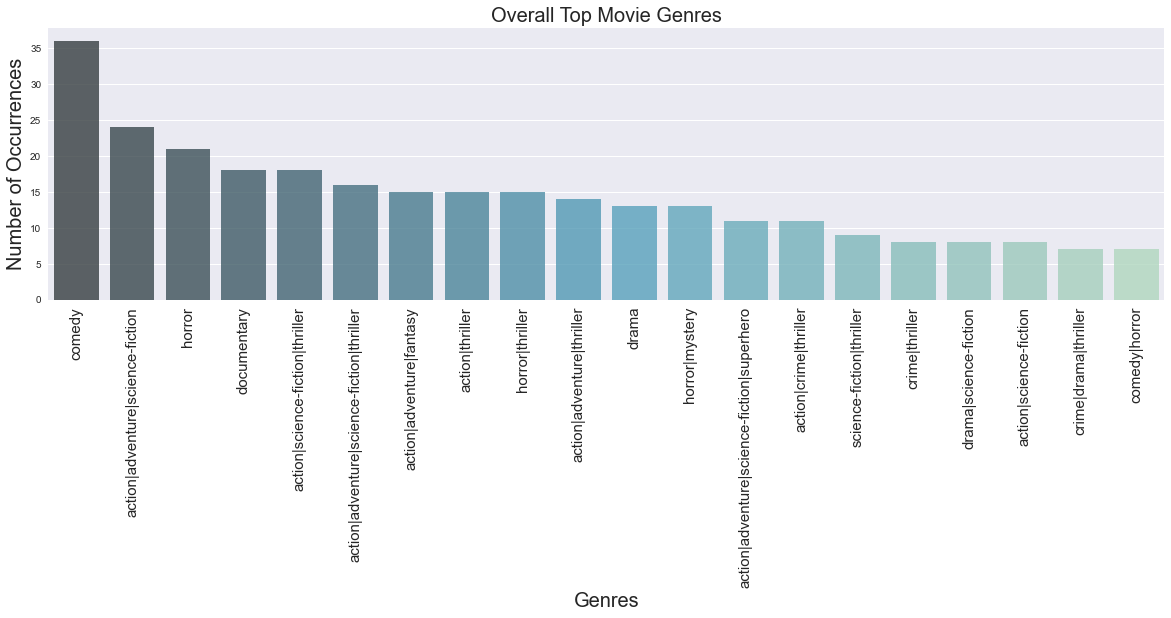

In [201]:
top_genres = df['genres'].value_counts(normalize=False)
top_genres = top_genres[:20,]

plt.figure(figsize=(20,5))

sns.barplot(top_genres.index, top_genres.values, alpha=0.8, palette='GnBu_d')

plt.title('Overall Top Movie Genres', fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Genres', fontsize=20)
plt.xticks(rotation=90, fontsize=15)
plt.show()

In [203]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1

    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [204]:
genre_labels = set()
for s in df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

keyword_occurences, dum = count_word(df, 'genres', genre_labels)
keyword_occurences[:3]

[['action', 423], ['thriller', 327], ['science-fiction', 315]]

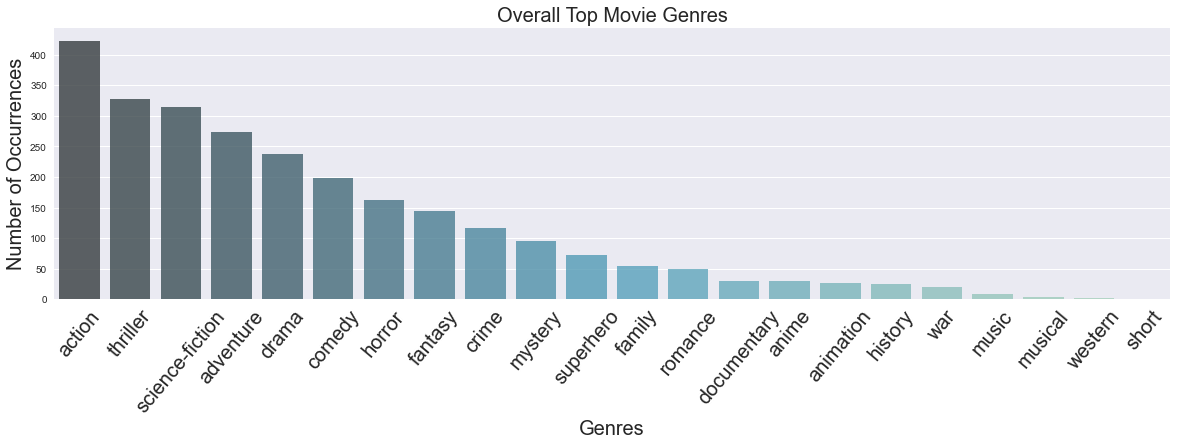

In [205]:
plt.figure(figsize=(20,5))
labels, ys = zip(*keyword_occurences)
xs = np.arange(len(labels)) 

sns.barplot(xs, ys, alpha=0.8, palette='GnBu_d')

plt.title('Overall Top Movie Genres', fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Genres', fontsize=20)
plt.xticks(xs,labels, rotation=50, fontsize=20)
plt.show()

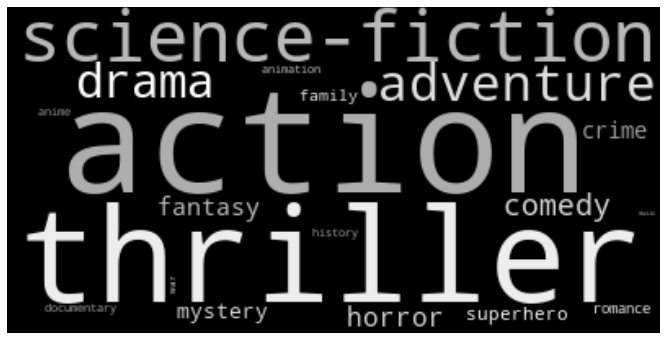

In [23]:
import random

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

words = dict()
for s in keyword_occurences:
    words[s[0]] = s[1]

f, ax = plt.subplots(figsize=(20, 6))

wordcloud = WordCloud(color_func=grey_color_func)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [24]:
df['decade'] = df['year'].apply(lambda x:((x-1900)//10)*10)

# function that extract statistical parameters from a grouby objet:
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}

# Creation of a dataframe with statitical infos on each decade:
test = df['year'].groupby(df['decade']).apply(get_stats).unstack()

In [25]:
test

,min,max,count,mean
decade,,,,
60,1968.0,1968.0,2.0,1968.000000
70,1972.0,1979.0,10.0,1976.600000
80,1980.0,1989.0,28.0,1985.500000
90,1990.0,1999.0,93.0,1995.548387
100,2000.0,2009.0,292.0,2005.150685
110,2010.0,2019.0,479.0,2014.409186
120,2020.0,2020.0,1.0,2020.000000


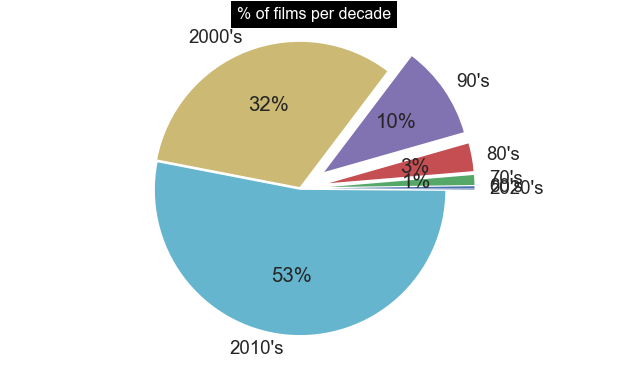

In [26]:
sns.set_context("poster", font_scale=0.85)

# funtion used to set the labels
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine

f, ax = plt.subplots(figsize=(11, 6))

labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(7)]

ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5}, color='w', fontsize=16);

df.drop('decade', axis=1, inplace = True)

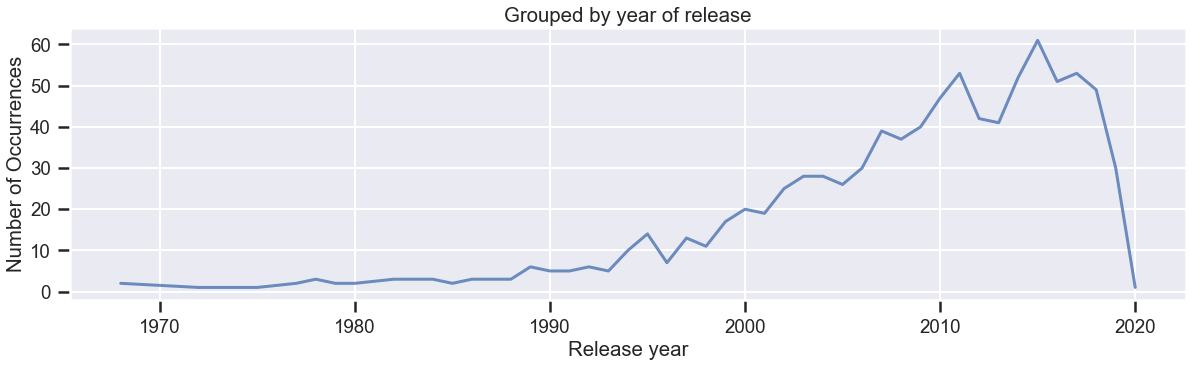

In [27]:
data = df['year'].value_counts().sort_index()

plt.figure(figsize=(20,5))

sns.lineplot(data.index, data.values, alpha=0.8, palette='GnBu_d')

plt.title('Grouped by year of release')
plt.ylabel('Number of Occurrences')
plt.xlabel('Release year')
plt.show()

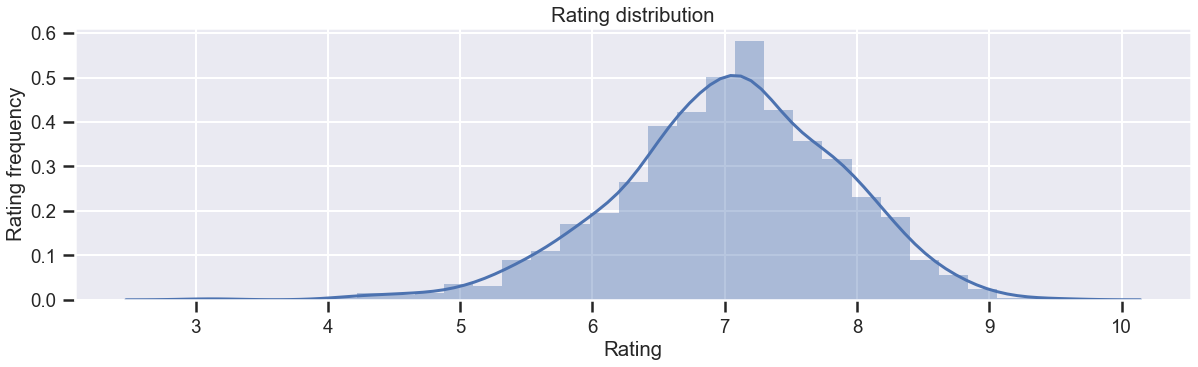

In [28]:
data = df['rating']

plt.figure(figsize=(20,5))

sns.distplot(data)

plt.title('Rating distribution')
plt.ylabel('Rating frequency')
plt.xlabel('Rating')
plt.show()

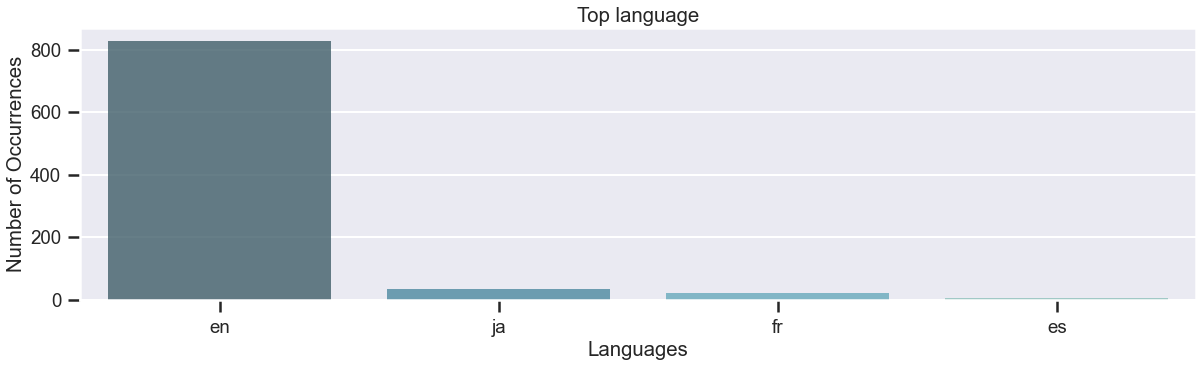

In [29]:
data = df['language'].value_counts(normalize=False)
data = data[:4,]

plt.figure(figsize=(20,5))

g = sns.barplot(data.index, data.values, alpha=0.8, palette='GnBu_d')

plt.title('Top language')
plt.ylabel('Number of Occurrences')
plt.xlabel('Languages')
plt.xticks()
plt.show()

In [182]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    
    for s in liste: keyword_count[s] = 0
        
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1

    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_count

In [183]:
def most_common_inclusive(freq_dict):
    # find the nth most common value
    nth_most_common = sorted(freq_dict.values(), reverse=True)[0]
    return { k: v for k, v in freq_dict.items() if v >= nth_most_common }

genre_labels = set()
for s in df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

keyword_occurences = count_word(df, 'genres', genre_labels)

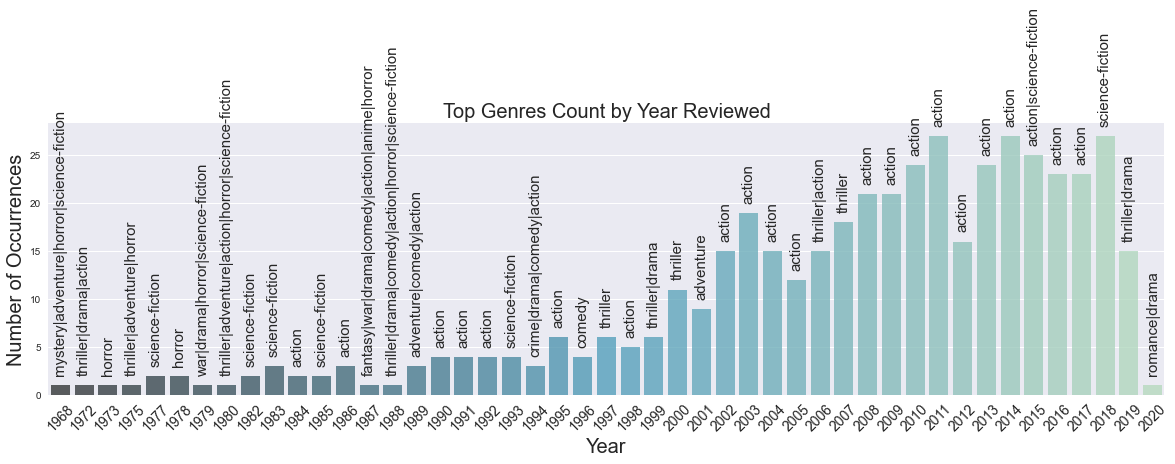

In [186]:
reviews_by_genres = df.groupby(['year']).apply(lambda x : count_word(x, 'genres', genre_labels)).reset_index()
reviews_by_genres[0] = reviews_by_genres[0].apply(most_common_inclusive)
reviews_by_genres['genres'] = reviews_by_genres[0].apply(lambda dict1 : '|'.join(x for x in dict1.keys()))
reviews_by_genres['counts'] = reviews_by_genres[0].apply(lambda dict1: list(dict1.values())[0])
reviews_by_genres.drop([0], axis=1, inplace=True)

plt.figure(figsize=(20,5))

g = sns.barplot(reviews_by_genres['year'], reviews_by_genres['counts'], alpha=0.8, palette='GnBu_d')

plt.title('Top Genres Count by Year Reviewed', fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.xticks(rotation=45, fontsize=14)


for index, row in reviews_by_genres.iterrows():
    g.text(row.name, row.counts + 1, row.genres, ha="center", rotation=90, 
           verticalalignment='bottom', fontsize=15)

plt.show()

In [225]:
df['description'] = df['tagline'] + ' ' + df['overview']
df['description'] = df['description'].fillna(' ')
df['description']

0      Everyone wants to be found. Two lost souls vis...
1      His time has come In the near future, a weary ...
2      This summer the Angels are back. The Angels ar...
3      Get Some Action Three women, detectives with a...
4      Live life at full brightness Two teens facing ...
                             ...                        
914    Welcome to the Real World. Set in the 22nd cen...
915    Life is like a box of chocolates...you never k...
916    Just because you are a character doesn't mean ...
917    Why So Serious? Batman raises the stakes in hi...
918    One giant leap into the unknown A look at the ...
Name: description, Length: 905, dtype: object

In [226]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 3),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['description'])

freqs = {word : tfidf_matrix.getcol(idx).sum() for word, idx in tf.vocabulary_.items()}


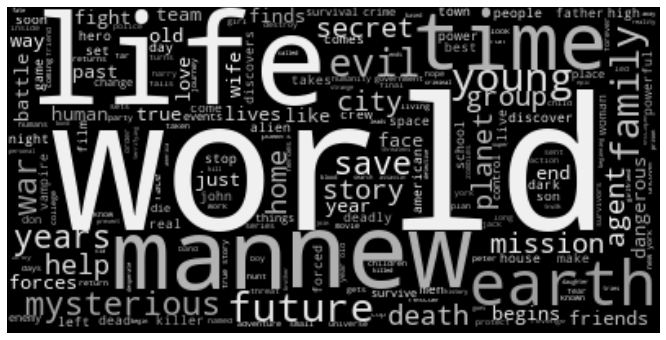

In [250]:
f, ax = plt.subplots(figsize=(20,6))

wordcloud = WordCloud(color_func=grey_color_func)
wordcloud.generate_from_frequencies(freqs)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Recommendation 

There is a lot of different way to recommend movie. The first method I will use is to make suggestions like "I watched this, so I might also be interested in that". I would really enjoy if when I scroll in my favorite app, I can click on my recently watched movie and access to similar movie.

A solution for this problem is to train a movie embedded model using meta information.

With the Trakt API we can't easy get meta data about movie like top-3 actors, director, writer and box-office. Thus, we will use the IMDBPY API (the official API of IMDb is undocumented)

Here we will use the most 10 000 popular movies according to Trakt. (Popularity is calculated using the rating percentage and the number of ratings.) Clearly not the best list of movies but it's a pretty good start.

In [15]:
# Get populer movies

headers = {
    'Content-Type': 'application/json',
    'trakt-api-version': '2',
    'trakt-api-key': CLIENT_ID
}

pop = 'https://api.trakt.tv/movies/popular?limit=10000'

resp = requests.get(pop, headers=headers)

response_body = resp.json()
len(response_body)
# print(response_body)
# for pretty json print, uncomment :
print(json.dumps(response_body[0], indent=2))

{
  "title": "Deadpool",
  "year": 2016,
  "ids": {
    "trakt": 190430,
    "slug": "deadpool-2016",
    "imdb": "tt1431045",
    "tmdb": 293660
  }
}


In [16]:
top_movies = pd.DataFrame()

for movie in response_body :
    top_movies = top_movies.append({
                        'title' : movie['title'],
                        'year' : movie['year'],
                        'imdb' : movie['ids']['imdb']
                            }, ignore_index=True)
    
top_movies.to_csv('data/top_10000_movies.csv', index=False)

In [17]:
top_movies = pd.read_csv('data/top_10000_movies.csv')
top_movies.head()

,imdb,title,year
0,tt1431045,Deadpool,2016.0
1,tt2015381,Guardians of the Galaxy,2014.0
2,tt0468569,The Dark Knight,2008.0
3,tt1375666,Inception,2010.0
4,tt3315342,Logan,2017.0


In [18]:
top_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   imdb    9988 non-null   object 
 1   title   10000 non-null  object 
 2   year    9999 non-null   float64
dtypes: float64(1), object(2)
memory usage: 234.5+ KB


In [5]:
from imdb import IMDb

# create an instance of the IMDb class
ia = IMDb()

# get a movie
movie = ia.get_movie('0133093')

# print the names of the directors of the movie
print('Directors:')
for director in movie['directors']:
    print(director['name'])

# print the genres of the movie
print('Genres:')
for genre in movie['genres']:
    print(genre)

# search for a person name
people = ia.search_person('Mel Gibson')
for person in people:
    print(person.personID, person['name'])

Directors:
Lana Wachowski
Lilly Wachowski
Genres:
Action
Sci-Fi
0000154 Mel Gibson
2153167 Mel Gibson
3323885 Adam Taylor
0317112 Mel Gibson
2800055 Mel Gibson
3742421 Melina Mari Bryant   nickname
0317195 Terel Gibson
0316945 Donal Gibson
0316878 Cal Gibson
2106809 Raquel Gibson
4047961 Noel Gibson
3912400 Jamel Gibson
0316950 E.L. Gibson
2798174 Daniel Gibson
9235742 Daniel Gibson
10402197 Daniel Gibson
7454542 L. Gibson
1270944 Paul Gibson
2988370 Mal Gibson
6928816 Christel Gibson


In [9]:
class GetMovieDetails(object):

    def __init__(self,movie):
        self.movie = movie

    def get_details(self,info_type):
        return self.movie.get(info_type)

    def movie_details(self):

        movie_details = {}

        movie_details['box_office'] = ', '.join('-' if self.get_details('box office') is None else {k + " - " + v for k, v in self.get_details('box office').items()})

        movie_details['languages'] = ', '.join('-' if self.get_details('languages') is None else self.get_details('languages'))

        movie_details['genres'] = ', '.join('-' if self.get_details('genres') is None else self.get_details('genres'))

        movie_details['cast'] = ', '.join('-' if self.get_details('cast') is None else [i['name'] for i in list(self.get_details('cast'))])

        movie_details['director'] = '-' if self.get_details('director') is None else self.get_details('director')[0]['name']

        movie_details['composers'] = '-' if self.get_details('composers') is None else self.get_details('composers')[0]['name']

        movie_details['synopsis'] = '-' if self.get_details('synopsis') is None else self.get_details('synopsis')[0]

        movie_details['plot'] = '-' if self.get_details('plot') is None else self.get_details('plot')[0]

        movie_details['kind'] = '-' if self.get_details('kind') is None else self.get_details('kind')

        movie_details['title'] = '-' if self.get_details('title') is None else self.get_details('title')

        movie_details['plot_outline'] = '-' if self.get_details('plot outline') is None else self.get_details('plot outline')

        movie_details['cover_url'] = '-' if self.get_details('cover url') is None else self.get_details('cover url')

        return movie_details

In [16]:
movie_id = '0133093'
movie = ia.get_movie(movie_id, info=['taglines', 'plot', 'main'])

movie_details_obj = GetMovieDetails(movie)
movie_details_dict = movie_details_obj.movie_details()

print(json.dumps(movie_details_dict, indent=2))

{
  "box_office": "Cumulative Worldwide Gross - $463,517,383, Opening Weekend United States - $27,788,331, 04 Apr 1999, Budget - $63,000,000 (estimated)",
  "languages": "English",
  "genres": "Action, Sci-Fi",
  "cast": "Keanu Reeves, Laurence Fishburne, Carrie-Anne Moss, Hugo Weaving, Gloria Foster, Joe Pantoliano, Marcus Chong, Julian Arahanga, Matt Doran, Belinda McClory, Anthony Ray Parker, Paul Goddard, Robert Taylor, David Aston, Marc Aden Gray, Ada Nicodemou, Deni Gordon, Rowan Witt, Eleanor Witt, Tamara Brown, Janaya Pender, Adryn White, Natalie Tjen, Bill Young, David O'Connor, Jeremy Ball, Fiona Johnson, Harry Lawrence, Steve Dodd, Luke Quinton, Lawrence Woodward, Michael Butcher, Bernard Ledger, Robert Simper, Chris Pattinson, Nigel Harbach, Mike Duncan, Nash Edgerton, Rana Morrison, Steve Rutherford",
  "director": "Lana Wachowski",
  "composers": "Don Davis",
  "synopsis": "The screen fills with green, cascading code which gives way to the title, The Matrix (1999).A phone

In [ ]:

movie = client.imdbid('tt1431045', tomatoes=False)
df = pd.DataFrame(columns=movie.keys())
error = []

for idIMDB in top_movies['imdb']:
    
    try : 
        movie = client.imdbid(idIMDB, tomatoes=False)
        movie['ratings'] = [movie['ratings']] # avoid bug from DataFrame.to_dict() 
        movie_set = pd.DataFrame.from_dict(movie)
        df = pd.concat([df, movie_set], axis =0, sort=False)
    except :
        print(idIMDB)
        error.append(idIMDB)
        

tt6628394
tt0359013
tt0472399
tt0499448
tt0175142
tt4520988
tt0034492
tt0478087
tt0032910
tt0118655
tt0119488
tt5814060
tt0107120
tt1599348
tt0102057
tt1482459
tt0914798
tt1086772
tt7401588
tt0094012
tt2091256
tt1413492
tt3564472
tt0800039
tt0119396
tt0396269
tt0190590
tt0810819
tt0033563
tt1931533
tt0485947
tt0389790
tt1605630
tt8106534
tt0087538
tt3316948
tt0080455
tt3348730
tt4698684
tt1291570
tt1082807
tt2180411
tt0094625
tt0117008
tt0252866
tt2066051
tt1860353
tt1872194
tt0106697
tt1155076
tt0079501
tt1956620
tt0963966
tt1980929
tt4361050
tt0472033
tt4532826
tt5083738
tt1855325
tt0910936
tt0118880
tt0458481
tt0196229
tt0053285
tt0203009
tt0955308
tt0120655
tt0145660
tt0086960
tt0414387
tt0478311
tt1855199
tt0088323
tt5886046
tt0286106
tt0475290
tt0432283
tt2357291
tt2191701
tt2203939
tt0113189
tt1206885
tt2452042
tt0129387
tt0287978
tt0065421
tt0838283
tt1028532
tt0091763
tt6663582
tt1611224
tt1220719
tt0099810
tt0479884
tt0327056
tt4139124
tt2361317
tt1401152
tt1899353
tt3095734


tt2888046
tt8350360
tt1233227
tt2388771
tt0075686
tt2268016
tt2493486
tt0970866
tt0146882
tt1559547
tt0047478
tt0093894
tt0978762
tt0082340
tt0315733
tt0345950
tt3845232
tt1187064
tt0095489
tt0092007
tt0362270
tt2231253
tt1527186
tt1126590
tt0453451
tt0318403
tt0095956
tt0096256
tt0333766
tt3707104
tt2051879
tt0397535
tt0415306
tt0056592
tt5390504
tt4622512
tt6924650
tt3799232
tt0104691
tt5254868
tt4547194
tt0227538
tt3352390
tt0085959
tt2980592
tt1542768
tt1001508
tt0497465
tt0081398
tt0815236
tt0130623
tt0200550
tt4158096
tt2910904
tt0130827
tt1314655
tt5884234
tt1563738
tt0253754
tt0096061
tt0172493
tt0832266
tt3315656
tt1262416
tt0102059
tt5117876
tt2273657
tt0251075
tt3203616
tt0377981
tt1386932
tt2937696
tt3064298
tt0838221
tt1219342
tt0120484
tt0454945
tt3203606
tt4954522
tt6679794
tt0408306
tt6214928
tt0491175
tt0988595
tt0057115
tt0108550
tt0096446
tt0099700
tt3319920
tt0080761
tt0066999
tt1120985
tt0861739
tt1072748
tt0349683
tt1569923
tt1091722
tt0960731
tt0117381
tt0259446


tt0277371
tt0368226
tt6048930
tt0114558
tt7137846
tt3181822
tt1034415
tt0063350
tt3321300
tt0311289
tt1116184
tt2626350
tt1740707
tt0105690
tt2328900
tt0907657
tt0409182
tt2126357
tt0084503
tt0765010
tt0852713
tt1045772
tt0164052
tt0471711
tt4262980
tt7043012
tt3860916
tt6857166
tt0099077
tt2800240
tt0436058
tt2378507
tt4901306
tt0938330
tt0096734
tt1672723
tt1255919
tt5452780
tt6673612
tt1935194
tt2364897
tt1837703
tt0821640
tt1023114
tt6195094
tt0765446
tt0091419
tt1226273
tt0272338
tt0105665
tt3169706
tt2614684
tt0464154
tt0383216
tt0465538
tt0109707
tt8201170
tt0120913
tt5962210
tt0097778
tt0093629
tt0164334
tt1800741
tt5664636
tt0139809
tt0375063
tt2027128
tt2597768
tt0316396
tt6491178
tt1440728
tt2483260
tt0104694
tt2247732
tt0472062
tt0312528
tt0070511
tt7451284
tt0146838
tt0817177
tt0494238
tt0119738
tt1661382
tt7374948
tt5816682
tt0462335
tt0368008
tt0758766
tt0460740
tt0077975
tt0113957
tt0115491
tt3139072
tt0318649
tt2674430
tt4687108
tt0395584
tt0050825
tt1767354
tt0420293


tt4411596
tt0491152
tt1054487
tt0120694
tt0096969
tt0036775
tt0102803
tt0243736
tt5691670
tt0825283
tt1583420
tt1055366
tt1592873
tt0099472
tt8361028
tt0098258
tt0088000
tt4034452
tt4341582
tt6348138
tt0195945
tt1758692
tt0092493
tt0035423
tt4587366
tt0463034
tt0171804
tt0107131
tt0445990
tt6141246
tt5789976
tt0110443
tt8781414
tt0102070
tt1532503
tt1798188
tt0091541
tt0043456
tt0113540
tt0111512
tt0114388
tt3007132
tt0088161
tt1289403
tt2113681
tt1703957
tt0098282
tt0116040
tt6908274
tt0097216
tt1588334
tt0110216
tt0112453
tt2338151
tt8085790
tt0111438
tt0397078
nan
tt2428170
tt0426592
tt1064932
tt0356680
tt3750872
tt1655420
tt0866439
tt5111874
tt0168629
tt0042192
tt0120679
tt6722030
tt1588878
tt0066206
tt2668134
tt1500491
tt0108255
tt7458762
tt0209475
tt0297284
tt1167638
tt9354944
tt0391304
tt0191397
tt0075029
tt5727282
tt1216515
tt3442006
tt0266489
tt3312868
tt0032976
tt1999995
tt0486551
tt1814621
tt1053810
tt2891174
tt0173886
tt0022100
tt1584016
tt0132347
tt1114677
tt0880578
tt0085

tt8096832
tt0105104
tt1826590
tt1705952
tt0119715
tt0072901
tt3859304
tt0947802
tt0398017
tt6063050
tt0430304
tt1646980
tt0384680
tt5175450
tt7690670
tt5179598
tt0116669
tt4291600
tt7083526
tt0124315
tt0094137
tt0253867
tt0052311
tt2980472
tt1683043
tt0108500
tt9252508
tt0090887
tt2737050
tt0104361
tt0065214
tt0089155
tt1073498
tt1166827
tt8022928
tt3612320
tt1305591
tt2167202
tt0066026
tt1535616
tt0240468
tt2309260
tt0268397
tt0144528
tt1720616
tt0024216
tt1213648
tt3758162
tt1233301
tt0082186
tt3286052
tt0104254
tt4814760
tt1590089
tt1172991
tt0228333
tt0101587
tt0078935
tt5480340
tt9354842
tt0472198
tt2093991
tt0025316
tt0057413
tt0091080
tt2071550
tt0125659
tt0166896
tt6198946
tt2944198
tt1464174
tt6868216
tt6902676
tt0371823
tt1674784
tt0054387
tt1945084
tt1999890
tt0144214
tt0405469
tt0478134
tt2372251
tt0111495
tt0429591
tt2309961
tt3895884
tt0120148
tt0056923
tt0048424
tt1205535
tt0395479
tt1156466
tt1316536
tt1384590
tt5635086
tt0120595
tt2315596
tt1152758
tt2011159
tt2375605


tt0060390
tt0107302
tt0078480
tt6595896
tt0113845
tt0092610
tt2061702
tt0411951
tt4181782
tt0810827
tt3707106
tt0104409
tt2145829
tt4015500
tt0074937
tt0082085
tt0929425
tt3450900
tt2258345
tt5193784
tt0120094
tt0303933
tt8613070
tt0460829
tt2085910
tt5577742
tt8836988
tt2085930
tt2306745
tt0303714
tt0110950
tt1477837
tt0241760
tt5929754
tt2309021
tt6793580
tt1905040
tt3305308
tt1588398
tt0337697
tt1361318
tt0856288
tt6951892
tt3029558
tt1713476
tt5501104
tt0026029
tt0061747
tt0913354
tt7390588
tt0109836
tt6969946
tt0305669
tt0804522
tt0465502
tt3208026
tt0111742
tt1031969
tt7054636
tt4776564
tt0068767
tt1582248
tt0368667
tt4365566
tt1176740
tt1821641
tt2235779
tt3810760
tt6574146
tt2784512
tt0109635
tt0446013
tt6900448
tt0092948
tt1226271
tt0104684
tt1924394
tt0093191
tt0892255
tt4796122
tt0078767
tt0218922
tt4537842
tt1545754
tt2908228
tt1213644
tt5702566
tt2464018
tt4420704
tt1560985
tt6169694
tt3268668
tt0365545
tt0425430
tt0029843
tt0067800
tt0093493
tt6163356
tt5213534
tt0471041


tt7615052
tt5814592
tt0441881
tt1287845
tt0067927
tt0198021
tt0285462
tt1901024
tt1977895
tt3508840
tt0254455
tt0964539
tt0045061
tt0106226
tt1204340
tt1480285
tt1773753
tt5066574
tt3318750
tt0080516
tt0467110
tt1756750
tt3778010
tt2981768
tt4073890
tt0857190
tt1020990
tt1182350
tt0107387
tt2295722
tt0110200
tt1016268
tt3704538
tt8271714
tt0348121
tt1754264
tt4285496
tt0030341
tt3588588
tt5039994
tt8820590
tt6294892
tt3482378
tt0165832
tt0070707
tt1084950
tt0057197
tt0086637
tt1603257
tt1067765
tt0094336
tt1837636
tt1883367
tt0120399
tt1974420
tt0109440
tt0380599
tt0188674
tt0102782
tt5960374
tt4189260
tt6063090
tt0114608
tt4171032
tt0057193
tt0082533
tt5774060
tt2752758
tt2429074
tt0113986
tt4262142
tt0248845
tt0119695
tt0117631
tt1174730
tt0037008
tt0185014
tt1758595
tt0808399
tt0360139
tt0114367
tt0113114
tt2473794
tt3715406
tt2911668
tt1526300
tt0100404
tt0119472
tt0384642
tt4006302
tt0080661
tt0486761
tt1911662
tt4457344
tt2337576
tt1528313
tt0964587
tt0083943
tt0488604
tt0433771


tt0157503
tt0803061
tt2677722
tt0101635
tt2091240
tt0095519
tt5662106
tt1661420
tt5475710
tt0334541
tt2660118
tt0070510
tt4610748
tt0095188
tt0180734
tt8523334
tt3155328
tt0078163
tt0331933
tt4537888
tt3214286
tt0111419
tt0117603
tt0937375
tt1999987
tt1313139
tt0399327
tt0112760
tt4486986
tt2524674
tt0082432
tt5173032
tt0077294
tt1068646
tt1143143
tt3409392
tt2599716
tt0033045
tt5033790
tt6238896
tt0357507
tt4911996
tt0018773
tt5902138
tt1634121
tt1132623
tt3438354
tt4158624
tt3202202
tt2069797
tt0314498
tt2231489
tt0112870
tt0357111
tt0780567
tt0479500
tt0141098
tt0079641
tt0089560
tt0116654
tt0044008
tt0366780
tt7816392
tt6859418
tt3655414
tt3807900
nan
tt2082197
tt1634136
tt0055032
tt0107007
tt1532958
tt1633356
tt5912454
tt1254207
tt1654523
tt3317522
tt1016301
tt2130321
tt3138344
tt2911674
tt0095107
tt0102015
tt0160184
tt1196956
tt0231775
tt0109035
tt0097240
tt0401085
tt0131646
tt2215285
tt9426852
tt0347304
tt2714900
tt4832640
tt0326905
tt3894404
tt0083630
tt0419294
tt0142239
tt0096

tt0158811
tt0278731
tt1436568
tt5739680
tt0455612
tt8009314
tt4919484
tt2251281
tt1744776
tt4327752
tt4917224
tt1079959
tt4902716
tt4370784
tt0162677
tt0076257
tt0101026
tt0077269
tt5251328
tt6832388
tt0126388
tt0050783
tt0093857
tt11388406
tt1164983
tt1231277
tt0166396
tt0841044
tt0085601
tt7095482
tt5160928
tt1666335
tt1137470
tt8809652
tt1105729
tt0080716
tt0072288
tt1853614
tt1123373
tt1604171
tt3917210
tt0155753
tt7364706
tt0041546
tt1024943
tt0034587
tt0953318
tt3756788
tt0104839
tt3700456
tt0409184
tt1158939
tt1420554
tt0988982
tt0037382
tt0384116
tt0110613
tt0109439
tt4647900
tt6104206
tt0266425
tt2488778
tt0080057
tt0080979
tt1134854
tt7339826
tt5921218
tt0099385
tt0034248
tt0094072
tt5355872
tt5797184
tt0102004
tt3521134
tt7157574
tt0116477
tt3182620
tt4969044
tt1018818
tt1830748
tt0049261
tt1650536
tt5083702
tt5697572
tt0078087
tt7236034
tt7461200
tt0051808
tt0204626
tt4400038
tt2338424
tt3910602
tt0110678
tt4410000
tt0420332
tt0417433
tt0052893
tt0312843
tt3919322
tt0085127

In [ ]:
df.head()

Extended Info

Returns all `cast` and `crew` for a movie. Each `cast` member will have a `characters` array and a standard `person` object.

The `crew` object will be broken up into `production`, `art`, `crew`, `costume & make-up`, `directing`, `writing`, `sound`, `camera`, `visual effects`, `lighting`, and `editing` (if there are people for those crew positions). Each of those members will have a `jobs` array and a standard `person` object.


From the [Trakt API Documentation](https://trakt.docs.apiary.io/)

In [253]:
# get all people for a movie
movie = 'lost-in-translation-2003'
all_people = 'https://api.trakt.tv/movies/{}/people'.format(movie)
resp = requests.get(all_people, headers=headers)

response_body = resp.json()
# print(response_body)
# for pretty json print, uncomment :
print(json.dumps(response_body['cast'][:3], indent=2))

[
  {
    "character": "Bob Harris",
    "characters": [
      "Bob Harris"
    ],
    "person": {
      "name": "Bill Murray",
      "ids": {
        "trakt": 411482,
        "slug": "bill-murray",
        "imdb": "nm0000195",
        "tmdb": 1532,
        "tvrage": 11014
      }
    }
  },
  {
    "character": "Charlotte",
    "characters": [
      "Charlotte"
    ],
    "person": {
      "name": "Scarlett Johansson",
      "ids": {
        "trakt": 5656,
        "slug": "scarlett-johansson",
        "imdb": "nm0424060",
        "tmdb": 1245,
        "tvrage": 52154
      }
    }
  },
  {
    "character": "John",
    "characters": [
      "John"
    ],
    "person": {
      "name": "Giovanni Ribisi",
      "ids": {
        "trakt": 297479,
        "slug": "giovanni-ribisi",
        "imdb": "nm0000610",
        "tmdb": 1771,
        "tvrage": 20175
      }
    }
  }
]


In [256]:
print(json.dumps(response_body['crew'], indent=2))

{
  "production": [
    {
      "job": "Executive Producer",
      "jobs": [
        "Executive Producer"
      ],
      "person": {
        "name": "Fred Roos",
        "ids": {
          "trakt": 588,
          "slug": "fred-roos",
          "imdb": "nm0740407",
          "tmdb": 2871,
          "tvrage": 119066
        }
      }
    },
    {
      "job": "Producer",
      "jobs": [
        "Producer"
      ],
      "person": {
        "name": "Ross Katz",
        "ids": {
          "trakt": 1698,
          "slug": "ross-katz",
          "imdb": "nm0441839",
          "tmdb": 1777,
          "tvrage": null
        }
      }
    },
    {
      "job": "Producer",
      "jobs": [
        "Producer"
      ],
      "person": {
        "name": "Francis Ford Coppola",
        "ids": {
          "trakt": 5976,
          "slug": "francis-ford-coppola",
          "imdb": "nm0000338",
          "tmdb": 1776,
          "tvrage": 64559
        }
      }
    },
    {
      "job": "Associate Produc